In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.insert(0, '..')

import numpy as np
import pandas as pd

from batchflow import Pipeline, B, V, I, M, C, plot, set_gpus
from batchflow.models.torch import TorchModel, VGGBlock

from src.loader import ImagesDataset

set_gpus()

`CUDA_VISIBLE_DEVICES` set to "5"


/notebooks/taine/notebooks/../batchflow/batchflow/plotter/cmaps.py:8: UserWarning: Trying to register the cmap 'batchflow' which already exists.
  register_cmap('batchflow', BATCHFLOW_CMAP)


[5]

In [3]:
seed = 11
rng = np.random.default_rng(seed)

In [4]:
%%time

DATA_PATH = '../images'
SHAPE = (128, 128, 3)

dataset = ImagesDataset(path=DATA_PATH, encode_labels=True, normalize=True, resize_shape=SHAPE)
n_classes = dataset.label_encoder.classes_.size

dataset.split(shuffle=seed)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/203 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

CPU times: user 17.6 s, sys: 25.2 s, total: 42.8 s
Wall time: 14.3 s


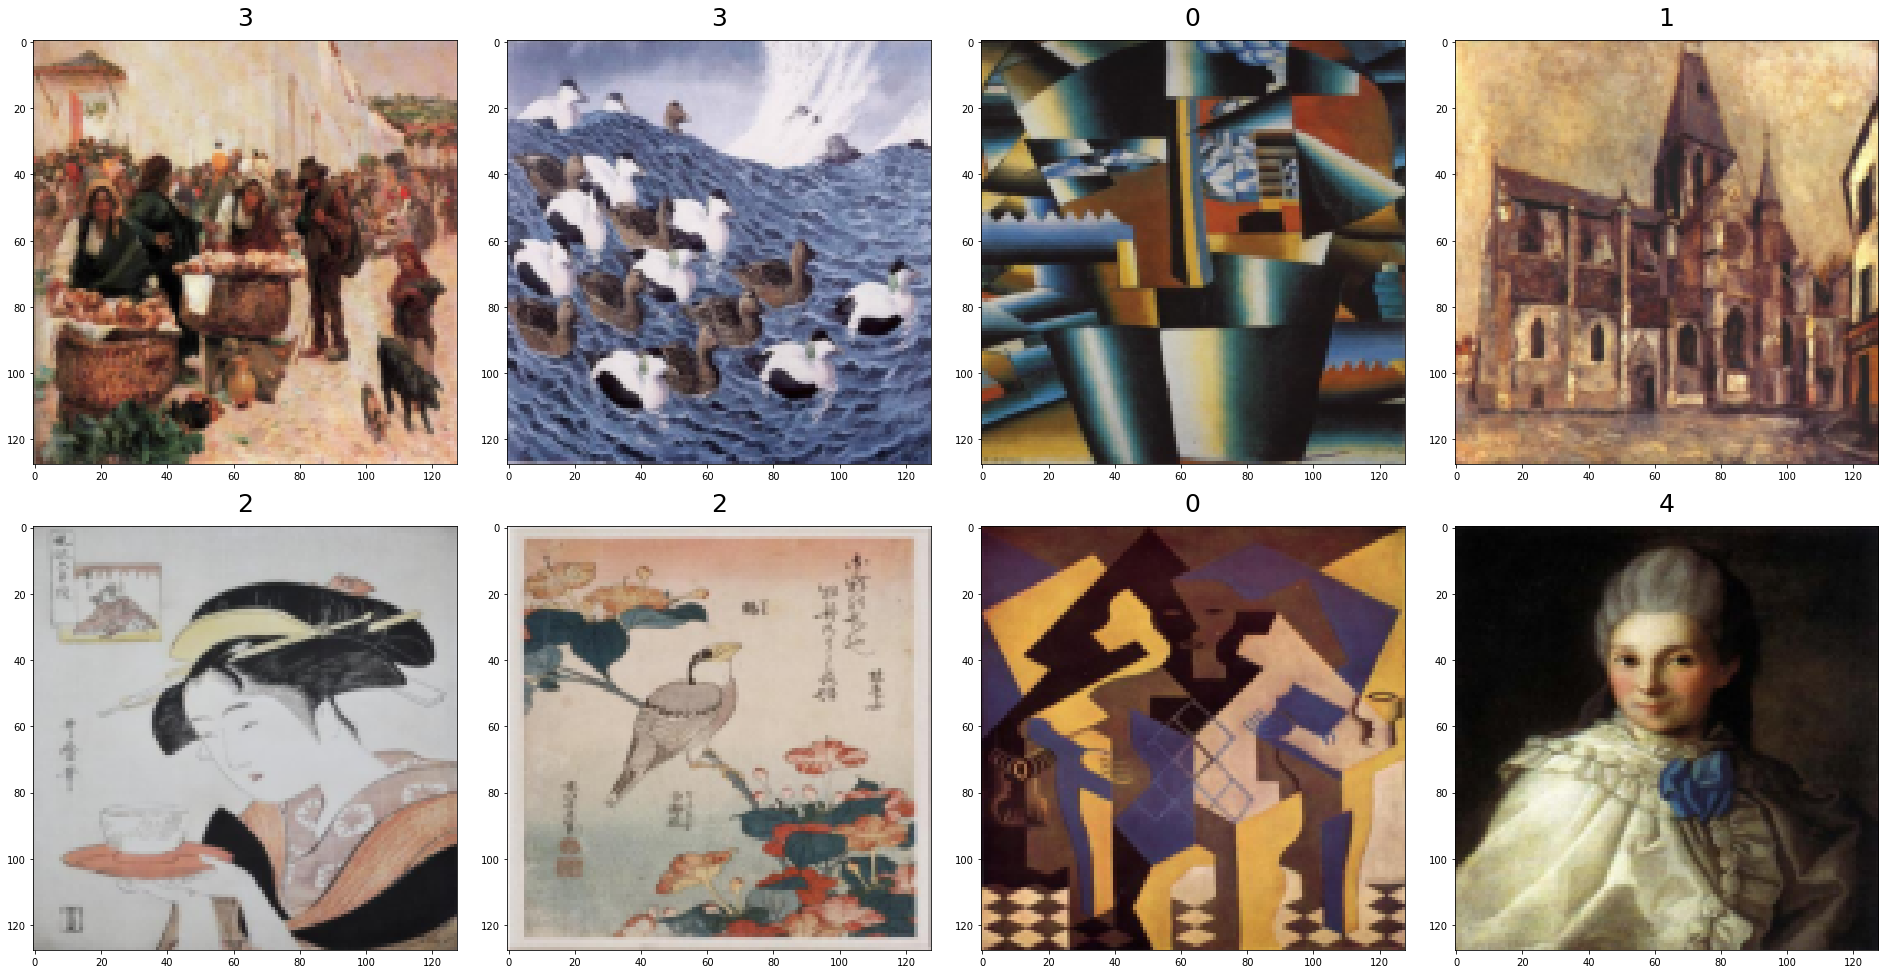

In [5]:
indices = rng.choice(range(dataset.size), 8)
images = list(dataset.images[indices])
labels = list(dataset.labels[indices])
plot(data=images, title=labels, combine='separate')

In [8]:
model_config = {
    'inputs/shapes': SHAPE[::-1],

    'body': {
        'type': 'encoder',
        'output_type': 'tensor',
        'order': ['block', 'downsampling'],
        'num_stages': 3,
        'blocks': {
            'base_block': VGGBlock,
            'channels': [64, 128, 256],
            'depth3': 2,
            'depth1': [0, 0, 1],
        },
    },

    'head': {
        'layout': 'Vdf',
        'dropout_rate': 0.4,
        'classes': n_classes
    },

    'common/conv/bias' : False,

    # Model training details:
    'init_model_weights': 'xavier',
    'loss': 'ce',
    'optimizer': 'Adam',
    'output': {'predicted': ['proba', 'labels']},
}

In [9]:
def evaluate(iteration, frequency, model, metrics, agg):
    if (iteration - 1) % frequency == 0:
        infer_pipeline = infer_template << dataset.test << {'model': model}
        infer_pipeline.run(batch_size=dataset.test.size, n_epochs=1, drop_last=False)
        metrics_value = infer_pipeline.v('metrics').evaluate(metrics=metrics, agg=agg)
        return [metrics_value] * frequency
    return []
        
train_template = (
    Pipeline()
    .to_array(channels='first', dtype=np.float32)
    .init_variable(name='loss_history', default=[])
    .init_variable(name='test_metrics', default=[])
    .init_model(name='model', model_class=TorchModel, mode='dynamic', config=model_config)
    .train_model(name='model', inputs=B('images'), targets=B('labels'),
                 outputs='loss', save_to=V('loss_history', mode='a'))
    .call(evaluate, iteration=I(), model=M('model'), frequency=C('evaluate/frequency'),
          metrics=C('evaluate/metrics'), agg=C('evaluate/metrics'), save_to=V('test_metrics', mode='e'))
)

infer_template = (
    Pipeline()
    .to_array(channels='first', dtype=np.float32)
    .init_variables('proba', 'predictions', 'metrics')
    .import_model('model', C('model'))
    .predict_model(name='model', inputs=B('images'),
                   outputs=['predicted_proba', 'predictions'],
                   save_to=[V('proba'), V('predictions')])
    .gather_metrics('classification', targets=B('labels'), predictions=V('predictions'),
                    fmt='logits', num_classes=n_classes,
                    axis=1, save_to=V('metrics', mode='update'))
)

train_config = {
    'evaluate': {
        'frequency': 50,
        'metrics': 'accuracy',
    }
}

train_pipeline = train_template << dataset.train << train_config

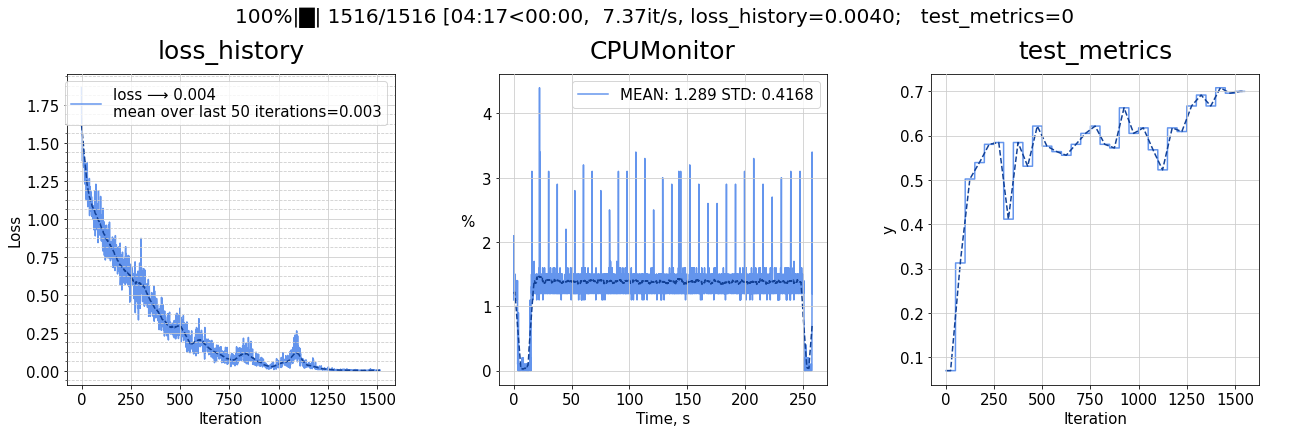

Exception ignored in: <function ResourceMonitor.__del__ at 0x7f094c4204c0>
Traceback (most recent call last):
  File "/notebooks/taine/notebooks/../batchflow/batchflow/monitor.py", line 88, in __del__
    super().__del__()
AttributeError: 'super' object has no attribute '__del__'


In [10]:
BATCH_SIZE = 128
FREQUENCY = 50
EPOCH_NUM = 200

notifier = {
    'bar': 'n', 'frequency': FREQUENCY,
    'graphs': ['loss_history', 'cpu', 'gpu', 'gpu_memory', 'test_metrics'],
}

_ = train_pipeline.run(batch_size=BATCH_SIZE, n_epochs=EPOCH_NUM, shuffle=True, notifier=notifier)

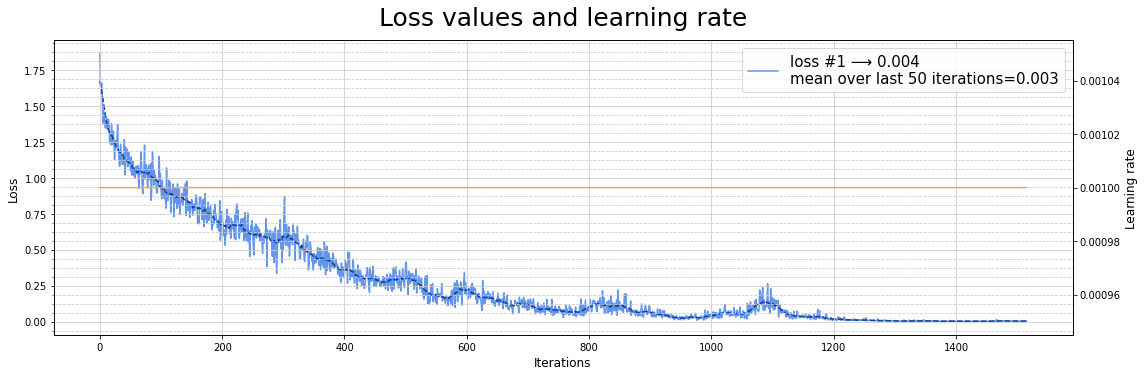

In [11]:
train_pipeline.model.plot_loss()

In [12]:
infer_pipeline = infer_template << dataset.test << {'model': train_pipeline.model}

In [13]:
infer_pipeline.run(batch_size=dataset.test.size, n_epochs=1, drop_last=False, bar='t')

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.01it/s]


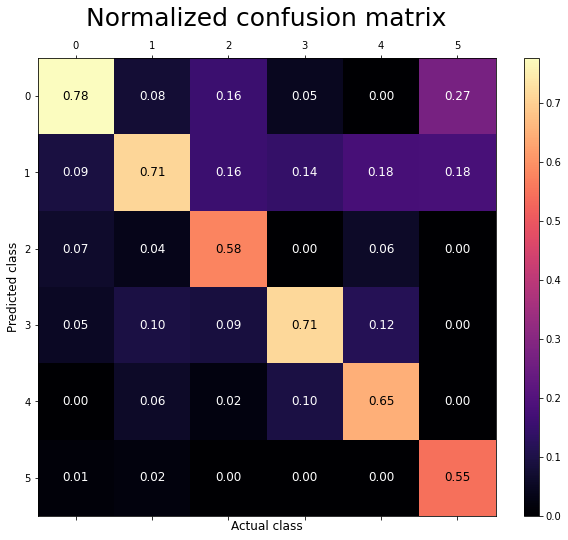

In [14]:
infer_pipeline.v('metrics').plot_confusion_matrix(normalize=True)

In [15]:
labels, counts = np.unique(dataset.labels[dataset.test.indices], return_counts=True)
shares = counts / counts.sum()

metrics = ['precision', 'recall']
metrics_dict = infer_pipeline.v('metrics').evaluate(metrics, multiclass=None)
metrics_df = pd.DataFrame({'names': dataset.label_encoder.classes_, 'shares': shares, **metrics_dict})

formatter = lambda value: value if isinstance(value, str) else f"{int(value * 100)}%"
metrics_df.style.background_gradient('RdYlGn', vmin=0, vmax=1, subset=metrics).format(formatter)

,names,shares,precision,recall
0,Cubism,31%,78%,77%
1,Impressionism,21%,59%,71%
2,Japonism,18%,76%,57%
3,Naturalism,17%,66%,71%
4,Rococo,6%,57%,64%
5,cartoon,4%,75%,54%
